# Experiments for the Eiknonal equation with non-homogenous domains


In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_cube import plot_2d_proj
from visualization.plots_disc import plot_2d_proj_disc

from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Cube import data_gen_cube
from PointSampling.Ball import data_gen_ball, data_gen_ball_unif
from NeuralNetworks.NNs import FCFF_3L, FCFF_4L


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [2]:
# Right hand sides

def f1(X):    
    return 1 - .8*torch.cos(X[:,0])

def f2(X):    
    return 1 - .8*torch.cos(X[:,0])

def f3(X):    
    return 1. #.1*(6. - X.norm(1, dim = -1))**2

f_list = [f1, f2, f3]

#Boundary conditions

def g1(X):    
    return 0.

def g2(X):    
    return 0.

def g3(X): 
    out = torch.zeros(X.shape[0])
    out[X.norm(dim = -1) < 4.] = 8.
    out[X.norm(dim = -1) > 4.] = X[X.norm(dim = -1) > 4., 1]
    return 0.3*out

g_list = [g1, g2, g3]

# Domains
# 0: cube
# 1: ball
# 2: annulus
domain_list = [0, 1, 2]

In [3]:
# Dimension of the domain for each experiment
dim_list = [2,2,2]
# Architecture in each experiment
arch_list = [2*[30],
             3*[30],
             3*[40]]


n_experiments = len(dim_list)
side_length = 6.
radii = [6., 2.]

# Parameters for each experiment
delta_list = [[.7, .3, .1]]*n_experiments
alpha_list = [[2.5, 1., .1]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments


num_iterations_list = [[1000, 2000, 3000],
                       [1000, 2000, 3000],
                       [2000, 3000, 4000]]

100%|██████████| 3000/3000 [00:05<00:00, 526.26it/s]
/Users/carlosesteveyague/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
../visualization/plots_cube.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


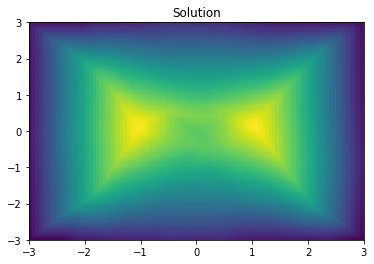

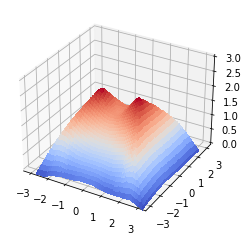

100%|██████████| 3000/3000 [00:07<00:00, 403.85it/s]
../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


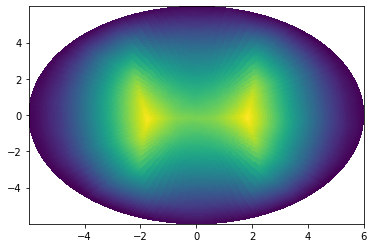

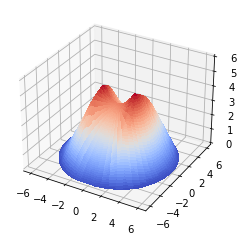

100%|██████████| 4000/4000 [00:11<00:00, 333.40it/s]


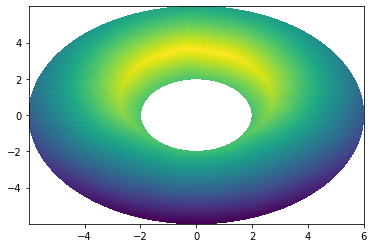

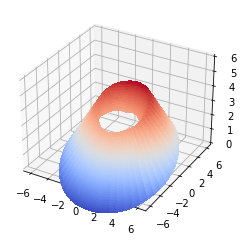

In [4]:
from Training.training import train

run_times = torch.zeros([n_experiments])

for j in range(n_experiments):
    
    if domain_list[j] == 0:
        domain = data_gen_cube(side_length, dim_list[j])
    elif domain_list[j] == 1:
        R = max(radii)
        domain = data_gen_ball([R,0.], dim_list[j])
    elif domain_list[j] ==2:
        domain = data_gen_ball(radii, dim_list[j])
    else:
        domain == None
    
    
    training_params['f'] = f_list[j]
    training_params['g'] = g_list[j]
    
    
    if len(arch_list[j]) == 2:        
        NN = FCFF_3L([dim_list[j]] + arch_list[j])
    else:
        NN = FCFF_4L([dim_list[j]] + arch_list[j])
    
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
    time = 0.
    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta'] = delta_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        t0 = t()
        total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
        time += t() - t0
    
    run_times[j] = time
    
    X_axis = 0
    Y_axis = 1
    
    if domain_list[j] == 0:
        n_x = 100
        plot_2d_proj(X_axis, Y_axis, NN, n_x, side_length)
    elif domain_list[j]== 1:
        n_theta = 100
        n_r = 100
        plot_2d_proj_disc(X_axis, Y_axis, NN, n_theta, n_r, [R, 0.])
    elif domain_list[j] == 2:
        n_theta = 100
        n_r = 100
        plot_2d_proj_disc(X_axis, Y_axis, NN, n_theta, n_r, radii)